# Minipset 3: Decentralized Path Planning
## Due Wednesday, April 29, 11:59 p.m.

In this problem set, you will implement **DMA-RRT** and use it to solve decentralized multiagent path-planning problems. Specifically, you will apply it to the VIPER path-planning scenario.

1. [Motivation](#motivation)
2. [Modeling](#modeling)
  1. [Modeling Example](#modeling-example)
  2. [Conceptual Question 1 - RRT (10 pts)](#concept1)
  3. [Conceptual Question 2 - Coordination (10 pts)](#concept2)
  4. [Conceptual Question 3 - Negative Bids (10 pts)](#concept3) 
3. [Implement DMA-RRT (20 pts x 2 = 40 pts)](#DMA-RRT)
4. [Cooperative DMA-RRT](#cooperative-dma-rrt)
  1. [Conceptual Question 4 - Global optimality vs. risk (10 pts)](#concept4) 
5. [Performance Analysis](#analysis)
  1. [Conceptual Question 5 - The Impact of $\Delta t$ (10 pts)](#concept5) 
  2. [Conceptual Question 6 - Limitations of DMA-RRT(10 pts)](#concept6) 

Make sure you load the following dependencies by highlighting the cell below and pressing `Shift + Enter`.

In [1]:
import copy
import itertools
import math
import random
import time
from uuid import uuid4
import yaml

from descartes import PolygonPatch
from matplotlib import pyplot as plt
import numpy as np
from pubsub import pub
from shapely import affinity
import shapely.geometry as geom
from shapely.geometry import Point

class Agent:
    def __init__(self,
                 mode,
                 received_bid,
                 received_waypoints,
                 start_pos,
                 goal_pos,
                 environment,
                 goal_dist,
                 rrt_iters):
        """ Initializer for Agent class; represents a robot capable of planning
            and moving in an environment.

            Args:
                mode: a string: "normal" or "cooperative" indicates whether to use
                    DMA-RRT or Cooperative DMA-RRT (respectively).
                received_bid: a method representing the callback for bid
                    messages passed over the network.
                received_waypoints: a method representing the callback for the
                    waypoints and winner_id messages passed over the network.
                start_pos: a 2-tuple representing the starting x-y position.
                goal_pos: a 2-tuple representing the goal x-y position.
                environment: an Environment object representing the map in which
                    the agent must plan.
                goal_dist: a float representing the length of a single branch in
                    the RRT tree for the agent's planner.
                rrt_iters: the number of iterations to run for RRT at each
                    spin_once.
        """
        self.antenna = Antenna()

        # Assign interaction callbacks for messages
        Agent.received_bid = received_bid
        Agent.received_waypoints = received_waypoints

        self.curr_time = 0.0  # Simulation time. Updated externally

        self.mode = mode
        self.token_holder = False

        # Keeps track of other agents' current bids for PPI
        #     (potential path improvement) at any given time:
        self.bids = dict()

        # Keeps track of other agents' plans so that we can
        #   add the other agents as obstacles when replanning:
        self.other_agent_plans = dict()

        # Initial state and environment
        self.start = start_pos
        self.goal = goal_pos
        self.pos = self.start
        self.environment = environment

        self.rrt = RRTstar(self.start, self.goal, self.environment, goal_dist,
                           max_iter=rrt_iters)
        self.goal_dist = goal_dist
        # curr_plan is the currently executing plan; best_plan is a lower-cost path
        #     than curr_plan, if one exists. The cost difference is the bid!
        self.curr_plan = Path()
        self.best_plan = Path()

        # Register as listener for different kinds of messages
        self.antenna.on_message("peers", self.received_id)
        self.antenna.on_message("bids", self.received_bid)
        self.antenna.on_message("waypoints", self.received_waypoints)

    """ The following methods represent the interaction component of DMA-RRT
        as described in algorithms 5 and 8.
    """
    ##########################################################################

    def broadcast_id(self):
        msg = {"topic":TOPIC_PEERS}
        self.antenna.broadcast(TOPIC_PEERS, msg)

    def received_id(self, sender_id, msg):
        if sender_id != self.antenna.uuid:
            self.bids[sender_id] = 0.0
            self.other_agent_plans[sender_id] = Path()

    def broadcast_bid(self, bid):
        msg = {"topic":TOPIC_BIDS, "bid":bid}
        self.antenna.broadcast(TOPIC_BIDS, msg)

    def broadcast_waypoints(self, winner_id):
        msg = {"topic":TOPIC_WAYPOINTS, "plan":self.curr_plan, "winner_id":winner_id}
        self.antenna.broadcast(TOPIC_WAYPOINTS, msg)

    def received_bid(self, sender_id, msg):
        """ Callback for messages over the network. """
        raise NotImplementedError

    def received_waypoints(self, sender_id, msg):
        """ Callback for messages over the network. """
        raise NotImplementedError

    ##########################################################################

    def at_goal(self):
        """ Checks if the agent's current location is the goal location. """
        dist = np.sqrt((self.pos[0]-self.goal[0])**2 + \
                (self.pos[1]-self.goal[1])**2)
        if dist <= 0.3:
            return True
        return False

    def update_time(self, curr_time):
        """ Update the internal time counter. """
        self.curr_time = curr_time

    def spin(self, rate):
        """ Runs the agent's individual component on a timer until it is
            sufficiently close to the goal.

            Args:
                rate: float representing the rate for the spin, in Hz.
        """
        # go until agent has reached its goal state
        while not self.at_goal():
            self.spin_once()
            time.sleep(1.0 / rate)

    def spin_once(self):
        """ Runs the agent's individual DMA-RRT component once.

            The interaction component is handled using Agent callbacks.
        """
        # Move agent if we have reached the next node
        if self.curr_plan.nodes:
            if self.curr_time in self.curr_plan.ts_dict.keys():
                self.pos = (self.curr_plan.ts_dict[self.curr_time].x,
                            self.curr_plan.ts_dict[self.curr_time].y)

            # curr_time may have moved on past the plans timestamps
            elif self.curr_time > self.curr_plan.nodes[-1].stamp:
                self.pos = (self.curr_plan.nodes[-1].x,
                            self.curr_plan.nodes[-1].y)


def test_received_bid(self, sender_id, msg):
    pass

def test_received_waypoints(self, sender_id, msg):
    pass

""" RRT* implementation in python. Based heavily on this source code by AtsushiSakai:
    https://github.com/AtsushiSakai/PythonRobotics

    This is intended for use with a 2D map.
"""

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.path_x = []
        self.path_y = []
        self.parent = None
        self.cost = 0.0

    def __str__(self):
        return "node xy: " + str(self.x) + ", " + str(self.y)

    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return (self.x == other.x) and (self.y == other.y)
        return False


class NodeStamped(Node):
    def __init__(self, node):
        super().__init__(node.x, node.y)
        self.path_x = node.path_x
        self.path_y = node.path_y
        self.parent = node.parent
        self.cost = node.cost
        self.stamp = None
    
    def __str__(self):
        return "node xy: " + str(self.x) + ", " + str(self.y) + \
               " | ts: " + str(self.stamp)

    def __eq__(self, other):
        if isinstance(other, self.__class__) or isinstance(other, Node):
            return (self.x == other.x) and (self.y == other.y)
        return False


class Path:    
    def __init__(self, nodes=[], start_node=None, goal_node=None, penalty=0):
        """ A representation of a path through a 2D map parametrized by time.

            This object should not be modified after initialization, except to add 
            emergency stops. For subpaths, create a new path object. This is the
            reason all fields are immutable when possible.
            If all arguments are default, the ctor will give the path infinite 
            cost. An empty path represents an infinite path, NOT a zero-cost path.

            Args:
                nodes: a list of NodeStamped objects representing the path.
                start_node: a NodeStamped representing the x-y position of the start.
                goal_node: a NodeStamped representing the x-y position of the goal.
                penalty: a float to be added to the cost of incomplete paths.
        """
        self.nodes = tuple(nodes)
        self.start_node = start_node
        self.goal_node = goal_node

        self.is_complete = False  # True if this Path goes from start to end
        self.cost = np.inf
        self.dist_to_goal = np.inf

        if self.nodes:
            if self.nodes[-1].x == self.goal_node.x and \
                    self.nodes[-1].y == self.goal_node.y:
                self.is_complete = True
                self.dist_to_goal = 0.0
            
            self.cost = self.nodes[-1].cost
            if not self.is_complete:
                self.cost += penalty  # Incomplete costs more than complete
                self.dist_to_goal = self.dist_between_nodes(self.nodes[-1],
                    NodeStamped(self.goal_node))
        
        # There is no frozendict! Do not modify this!
        self.ts_dict = {node.stamp : node for node in self.nodes}

    def __str__(self):
        writ = "Path start: " +  str(self.start_node) + \
               "\nPath goal: " + str(self.goal_node) + \
               "\nPath completion status: " + str(self.is_complete) + \
               "\nPath cost: " + str(self.cost) + \
               "\nPath dist_to_goal: " + str(self.dist_to_goal) + \
               "\nPath nodes length: " + str(len(self.nodes)) + \
               "\nPath nodes: "
        for node in self.nodes:
            writ += '\n\t' + str(node)
        
        return writ

    def dist_between_nodes(self, from_node, to_node):
        """ Compute the Euclidean distance between two nodes. """
        dx = from_node.x - to_node.x
        dy = from_node.y - to_node.y

        return np.sqrt(np.square(dx) + np.square(dy))

    def get_cost_between(self, from_id, to_id):
        """ Return the cost between two node IDs. 

            Args:
                from_id: an integer representing the id of the node in 
                    self.nodes from which the calculation is done.
                to_id: an integer representing the id of the node in 
                    self.nodes that is the destination.
                
            Returns: a float representing the cost between the nodes.
        """
        if to_id > 0:
            assert(to_id > from_id)

        from_cost = self.nodes[from_id].cost
        to_cost = self.nodes[to_id].cost

        return to_cost - from_cost


class RRTstar:
    def __init__(self, start, goal, env, goal_dist=0.5, goal_sample_rate=0.7,
                 path_resolution=0.1, connect_circle_dist=5.0, max_iter=1000):
        # Planner states
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.env = env
        self.curr_iter = 0
        self.node_list = [self.start]
        self.found_complete_path = False
        self.curr_time = 0

        # Planner parameters
        self.goal_dist = goal_dist
        self.goal_sample_rate = goal_sample_rate
        self.path_resolution = path_resolution
        self.connect_circle_dist = connect_circle_dist
        self.max_iter = max_iter

        # Persistent states 
        self.best_path = Path()
        self.curr_pos = self.start
        self.nodes_traveled = [self.start]

    def spin(self, return_first_path=False):
        """ Expand the tree and plan through the environment. """
        # print("RRTstar >> starting spin...")
        for iter in range(self.max_iter):
            path = self.spin_once(return_first_path)
            if path is not None:
                return path
            
        return self.get_path()

    def spin_once(self, return_first_path):
        """ Perform one iteration of tree-expansion and path-planning. """
        self.curr_iter += 1
        rand_node = self.get_rand_node()

        nearest_id = self.get_nearest_node_id(rand_node)
        near_node = self.node_list[nearest_id]
        new_node = self.steer(near_node, rand_node)

        if new_node is not None:
            if self.env.collision_free(new_node.x, new_node.y):
                near_ids = self.get_near_node_ids(new_node)
                new_node = self.choose_parent(new_node, near_ids)
                
                if new_node:
                    self.node_list.append(new_node)
                    self.rewire(new_node, near_ids)

            if return_first_path and new_node:
                return self.get_path()

        return None

    def steer(self, from_node, to_node):
        """ Drive the growth of the tree towards the goal point. """
        new_node = Node(from_node.x, from_node.y)
        d, theta = RRTstar.calc_dist_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        extend_length = self.goal_dist
        if extend_length > d:
            extend_length = d

        n_expand = np.floor(extend_length / self.path_resolution)
        for _ in range(int(n_expand)):
            new_node.x += self.path_resolution * np.cos(theta)
            new_node.y += self.path_resolution * np.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = RRTstar.calc_dist_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)

        new_node.parent = from_node

        if new_node != from_node:
            return new_node
        
        return None

    def choose_parent(self, new_node, near_ids):
        """ Choose parent for the new node based on nearest nodes. """
        if not near_ids:
            return None

        costs = []
        for id in near_ids:
            near_node = self.node_list[id]
            t_node = self.steer(near_node, new_node)

            if t_node and self.env.collision_free(t_node.x, t_node.y):
                costs.append(RRTstar.compute_new_cost(near_node, new_node))
            else:
                costs.append(np.inf)  # Collision nodes have inf cost.
            
        min_cost = min(costs)
        if min_cost == np.inf:
            return None
        
        min_id = near_ids[costs.index(min_cost)]
        new_node = self.steer(self.node_list[min_id], new_node)
        new_node.parent = self.node_list[min_id]
        new_node.cost = min_cost

        return new_node

    @staticmethod
    def compute_new_cost(from_node, to_node):
        """ Compute cost between two nodes. """
        d, _ = RRTstar.calc_dist_and_angle(from_node, to_node)
        return from_node.cost + d

    def search_best_goal_node(self):
        """ Identify the best goal node given the current path. """
        dist_to_goal_ls = [self.dist_to_goal(node) for node in self.node_list]
        goal_ids = [dist_to_goal_ls.index(i) \
                    for i in dist_to_goal_ls if i <= 1.1 * self.goal_dist]

        safe_goal_ids = []
        for id in goal_ids:
            t_node = self.steer(self.node_list[id], self.goal)

            if t_node and self.env.collision_free(t_node.x, t_node.y):
                safe_goal_ids.append(id)
        
        if len(safe_goal_ids) != 0:
            min_cost = min([self.node_list[i].cost for i in safe_goal_ids])
            for i in safe_goal_ids:
                if self.node_list[i].cost == min_cost:
                    return i
        
        return None

    def rewire(self, new_node, near_ids):
        """ Rewire cost of nearby nodes based on cost of the new node. """
        for id in near_ids:
            near_node = self.node_list[id]
            edge_node = self.steer(new_node, near_node)

            if edge_node:
                edge_node.cost = RRTstar.compute_new_cost(new_node, near_node)

                if near_node.cost > edge_node.cost and \
                        self.env.collision_free(edge_node.x, edge_node.y):
                    self.node_list[id] = edge_node
                    self.propagate_cost(new_node)

    def propagate_cost(self, parent_node):
        """ Propagate cost down the tree to all leaves of the parent. """
        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = RRTstar.compute_new_cost(parent_node, node)
                self.propagate_cost(node)

    def get_path(self):
        """ Attempt to find a path to a goal point. Returns the best path.

            If the best path found is incomplete, then it still returns this
            path.

            Returns: a Path object representing the current best path to the
                goal node.
        """
        last_id = self.search_best_goal_node()
        new_path = self.generate_final_path(last_id, self.curr_time)
        
        # Get cost of new path starting from current position
        cur_node_id = new_path.nodes.index(self.curr_pos)
        new_path_cost_adj = new_path.get_cost_between(cur_node_id, -1)

        # Get cost of best path starting from current position
        cur_node_id = None
        best_path_cost_adj = self.best_path.cost
        if self.best_path.nodes:
            cur_node_id = self.best_path.nodes.index(self.best_path.start_node)
            best_path_cost_adj = self.best_path.get_cost_between(cur_node_id, -1)

        # Choose the new path if we have complete paths and it's cheaper
        if self.found_complete_path:
            if (new_path_cost_adj < best_path_cost_adj) and \
                    new_path.is_complete:
                self.best_path = new_path
        else:
            # Choose the new path if it's complete and the best isn't
            if (new_path.is_complete) and (not self.best_path.is_complete):
                self.found_complete_path = True
                self.best_path = new_path
            # Choose the new path if its closer to the goal point
            elif new_path.dist_to_goal < self.best_path.dist_to_goal:
                self.best_path = new_path
        
        return self.best_path

    def generate_final_path(self, id=None, curr_time=0):
        """ Prune the final path once the goal has been found.
        
            Args:
                id: an integer representing the index of the node closest
                    to the goal point. If None, the resultant path is
                    incomplete
                start_time: a timestamp representing the starting time for
                    the path, passed to the time allocation routine
        """
        node = None
        path_nodes = []

        if id:
            # Complete path
            goal_node = NodeStamped(self.goal)
            goal_node.cost = RRTstar.compute_new_cost(
                self.node_list[id], self.goal)
            path_nodes = [goal_node]
        else:
            # Incomplete path
            dlist = [self.dist_to_goal(node) for node in self.node_list]
            id = dlist.index(min(dlist))

        node = self.node_list[id]

        while node.parent is not None:
            node_stamped = NodeStamped(node)
            path_nodes.append(node_stamped)
            node = node.parent

        path_nodes.append(NodeStamped(node))
        path_nodes.reverse()

        # Weird edge case where nodes are empty when close to goal
        if not path_nodes:
            return self.best_path

        # Allocate time to this part of the path
        path_nodes = self.allocate_time(path_nodes, curr_time)

        # Add the path already traveled
        if self.nodes_traveled:
            path_parent = self.nodes_traveled[-1]
            path_nodes[0].parent = path_parent
            for node in path_nodes:
                node.cost += path_parent.cost

            nodes_traveled_stamped = [
                    NodeStamped(node) for node in self.nodes_traveled]
            for node in nodes_traveled_stamped:
                node.stamp = 0  # Traveled nodes all have zero ts
            
            path_nodes = nodes_traveled_stamped + path_nodes

        path = Path(path_nodes,
                    NodeStamped(self.start),
                    NodeStamped(self.goal),
                    2.0 * max(self.env.bounds))
        return path

    def allocate_time(self, nodes, start_time):
        """ Attribute timestamps to each node in the nodes list.

            Args:
                nodes: a list of NodeStamped objects
                start_time: the start time for the first node in the list
        """
        
        def naive_alloc():
            """ Simply increment each stamp by one integer. """
            count = start_time
            for node in nodes:
                node.stamp = count
                count += 1
        
        naive_alloc()
        return nodes

    def dist_to_goal(self, node):
        """ Compute the Euclidean distance to the goal node. """
        dx = node.x - self.goal.x
        dy = node.y - self.goal.y

        return np.sqrt(np.square(dx) + np.square(dy))

    def get_rand_node(self):
        """ Return a random Node object within the prescribed confines. """
        if random.randint(0, 100) > self.goal_sample_rate:
            node = Node(random.uniform(self.env.bounds[0], self.env.bounds[2]),
                        random.uniform(self.env.bounds[1], self.env.bounds[3]))

        else:
            node = Node(self.goal.x, self.goal.y)
        
        return node

    def get_nearest_node_id(self, new_node):
        """ Return nearest node in the nodelist to the input node. """
        dlist = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2 \
                for node in self.node_list]

        minid = dlist.index(min(dlist))
        return minid

    def get_near_node_ids(self, new_node):
        """ Return all near nodes in the nodelist to the input node. """
        n = len(self.node_list) + 1
        r = self.connect_circle_dist * np.sqrt((np.log(n) / n))
        r = min(r, self.goal_dist)

        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2 \
                    for node in self.node_list]
        near_ids = [dist_list.index(i) for i in dist_list if i <= r**2]

        return near_ids

    @staticmethod
    def calc_dist_and_angle(from_node, to_node):
        """ Compute the distance and angle between two nodes. """
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = np.sqrt(np.square(dx) + np.square(dy))
        theta = np.arctan2(dy, dx)

        return d, theta
    
    def update_pos(self, pos, curr_time, wipe_tree=True):
        """ Store self agent current position for new tree generation.

            Note that this will wipe the existing tree, including the 
            node_list, if `wipe_tree` is set to True. This does not 
            reset `best_path` or `nodes_traveled`.
            Member updates only happen if the incoming position is not the
            same as the current recorded position (i.e. we haven't moved).
            Tree wipe doesn't happen if we haven't moved.

            Args:
                pos: a 2-tuple representing the x-y coordinates of the agent
                    running the RRT algorithm.
                curr_time: a time representing the current time of the sim.
                wipe_tree: a boolean; if True, the RRT tree will be reset.
        """
        new_pos = Node(pos[0], pos[1])
        self.curr_time = curr_time
        if new_pos != self.curr_pos:
            new_pos.cost = RRTstar.compute_new_cost(self.nodes_traveled[-1],
                                                    new_pos)
            self.nodes_traveled.append(new_pos)
            self.curr_pos = new_pos

            if wipe_tree:
                self.start = new_pos
                self.curr_iter = 0
                self.node_list = [self.start]

"""
Borrowed from 16.413 F19 pset 6
"""
def plot_environment(env, bounds=None, figsize=None):
    if bounds is None and env.bounds:
        minx, miny, maxx, maxy = env.bounds
    elif bounds:
        minx, miny, maxx, maxy = bounds
    else:
        minx, miny, maxx, maxy = (-10,-5,10,5)

    max_width, max_height = 12, 5.5
    if figsize is None:
        width, height = max_width, (maxy-miny)*max_width/(maxx-minx)
        if height > 5:
            width, height = (maxx-minx)*max_height/(maxy-miny), max_height
        figsize = (width, height)
    f = plt.figure(figsize=figsize)
    ax = f.add_subplot(111)
    for i, obs in enumerate(env.obstacles):
        patch = PolygonPatch(obs, fc='blue', ec='blue', alpha=0.5, zorder=20)
        ax.add_patch(patch)

    plt.xlim([minx, maxx])
    plt.ylim([miny, maxy])
    ax.set_aspect('equal', adjustable='box')
    return ax

def plot_line(ax, line, color):
    x, y = line.xy
    ax.plot(x, y, color=color, linewidth=3, solid_capstyle='round', zorder=1)

def plot_poly(ax, poly, color, alpha=1.0, zorder=1):
    patch = PolygonPatch(poly, fc=color, ec="black", alpha=alpha, zorder=zorder)
    ax.add_patch(patch)

class Environment:
    def __init__(self, yaml_file=None, bounds=None):
        self.yaml_file = yaml_file
        self.environment_loaded = False
        self.obstacles = []
        self.obstacles_map = {}
        self.bounds = bounds
        if not yaml_file is None:
            if self.load_from_yaml_file(yaml_file):
                if bounds is None:
                    self.calculate_scene_dimensions()
                self.environment_loaded = True

    def add_obstacles(self, obstacles):
        self.obstacles = self.obstacles + obstacles
        self.calculate_scene_dimensions()

    def calculate_scene_dimensions(self):
        """Compute scene bounds from obstacles."""
        points = []
        for elem in self.obstacles:
            points = points + list(elem.boundary.coords)

        mp = geom.MultiPoint(points)
        self.bounds = mp.bounds

    def collision_free(self, x, y):
        """ Check if a point is obstacle-free. """
        point = geom.Point(x, y)
        return not any([obstacle.contains(point) for obstacle in self.obstacles])

    def load_from_yaml_file(self, yaml_file):
        f = open(yaml_file)
        self.data = yaml.safe_load(f)
        f.close()
        return self.parse_yaml_data(self.data)

    def parse_yaml_data(self, data):
        if 'environment' in data:
            env = data['environment']
            self.parse_yaml_obstacles(env['obstacles'])
            return True
        else:
            return False

    def parse_yaml_obstacles(self, obstacles):
        self.obstacles = []
        self.obstacles_map = {}
        for name, description in obstacles.items():
            # Double underscore not allowed in region names.
            if name.find("__") != -1:
                raise Exception("Names cannot contain double underscores.")
            if description['shape'] == 'rectangle':
                parsed = self.parse_rectangle(name, description)
            elif description['shape'] == 'polygon':
                parsed = self.parse_polygon(name, description)
            else:
                raise Exception("not a rectangle")
            if not parsed.is_valid:
                raise Exception("%s is not valid!"%name)
            self.obstacles.append(parsed)
            self.obstacles_map[name] = parsed
        self.expanded_obstacles = [obs.buffer(0.75/2, resolution=2) for obs in self.obstacles]

    def parse_rectangle(self, name, description):
        center = description['center']
        center = geom.Point((center[0], center[1]))
        length = description['length']
        width = description['width']
        # convert rotation to radians
        rotation = description['rotation']# * math.pi/180
        # figure out the four corners.
        corners = [(center.x - length/2., center.y - width/2.),
                   (center.x + length/2., center.y - width/2.),
                   (center.x + length/2., center.y + width/2.),
                   (center.x - length/2., center.y + width/2.)]
        # print corners
        polygon = geom.Polygon(corners)
        out = affinity.rotate(polygon, rotation, origin=center)
        out.name = name
        out.cc_length = length
        out.cc_width = width
        out.cc_rotation = rotation
        return out

    def parse_polygon(self, name, description):
        _points = description['corners']
        for points in itertools.permutations(_points):
            polygon = geom.Polygon(points)
            polygon.name = name
            if polygon.is_valid:
                return polygon

    def save_to_yaml(self, yaml_file):
        yaml_dict = {}
        obstacles = {}
        for i, ob in enumerate(self.obstacles):
            ob_dict = {}
            ob_dict['shape'] = 'polygon'
            ob_dict['corners'] = [list(t) for t in list(ob.boundary.coords)]
            ob_name = "obstacle%.4d"%i
            obstacles[ob_name] = ob_dict
        yaml_dict['environment'] = {'obstacles' : obstacles}

        f = open(yaml_file, 'w')
        f.write(yaml.dump(yaml_dict, default_flow_style=None))
        f.close()

def random_environment(bounds, start, radius, goal, n, size_limits=(0.5, 1.5)):
    """
    Create a random environment of obstacles
    """
    minx, miny, maxx, maxy = bounds
    edges = 4
    minl, maxl = size_limits
    env = Environment(None)
    obs = []
    start_pose = Point(start).buffer(radius, resolution=3)
    obi = 0
    while obi < n:
        r = np.random.uniform(low=0.0, high=1.0, size=2)
        xy = np.array([minx + (maxx - minx) * r[0], miny + (maxy - miny) * r[1]])

        angles = np.random.rand(edges)
        angles = angles * 2 * np.pi / np.sum(angles)
        for i in range(1, len(angles)):
            angles[i] = angles[i - 1] + angles[i]
        angles = 2 * np.pi * angles / angles[-1]
        angles = angles + 2 * np.pi * np.random.rand()
        lengths = 0.5 * minl + (maxl - minl) * 0.5 * np.random.rand(edges)
        xx = xy[0] + np.array([l * np.cos(a) for a, l in zip(angles, lengths)])
        yy = xy[1] + np.array([l * np.sin(a) for a, l in zip(angles, lengths)])
        p = Polygon([(x, y) for x, y in zip(xx, yy)])
        if p.intersects(start_pose) or p.intersects(goal):
            continue
        else:
            obi = obi + 1
            obs.append(p)
    env.add_obstacles(obs)
    return env


def test_antenna_callback_bids(received_bid, received_waypoints):
    print("running test_antenna_callback_bids...\n")

    environment = Environment(yaml_file="utils/simple.yaml")

    agent1 = Agent(mode = "normal",
                   received_bid = received_bid,
                   received_waypoints = received_waypoints,
                   start_pos = (0, 0),
                   goal_pos = (10.5, 5.5),
                   environment = environment,
                   goal_dist = 0.3,
                   rrt_iters = 200)
    agent2 = Agent(mode = "normal",
                   received_bid = received_bid,
                   received_waypoints = received_waypoints,
                   start_pos = (2, 3),
                   goal_pos = (0, 4),
                   environment = environment,
                   goal_dist = 0.3,
                   rrt_iters = 200)

    agent1.broadcast_id()
    agent2.broadcast_id()

    agent1.broadcast_bid(10)
    agent2.broadcast_bid(20)

    assert agent2.bids[agent1.antenna.uuid] == 10
    assert agent1.bids[agent2.antenna.uuid] == 20

def test_antenna_callback_waypoints(received_bid, received_waypoints):
    print("running test_antenna_callback_waypoints...\n")

    environment = Environment(yaml_file="utils/simple.yaml")

    agent1 = Agent(mode = "normal",
                   received_bid = received_bid,
                   received_waypoints = received_waypoints,
                   start_pos = (0, 0),
                   goal_pos = (10.5, 5.5),
                   environment = environment,
                   goal_dist = 0.3,
                   rrt_iters = 200)
    agent2 = Agent(mode = "normal",
                   received_bid = received_bid,
                   received_waypoints = received_waypoints,
                   start_pos = (2, 3),
                   goal_pos = (0, 4),
                   environment = environment,
                   goal_dist = 0.3,
                   rrt_iters = 200)

    agent1.broadcast_id()
    agent2.broadcast_id()

    assert not agent1.token_holder
    assert not agent2.token_holder

    start = NodeStamped(Node(1, 2))
    end = NodeStamped(Node(2, 3))

    agent1.curr_plan = Path(nodes = [start, end],
                            start_node = start,
                            goal_node = end)
    agent1.broadcast_waypoints(agent2.antenna.uuid)

    assert agent2.other_agent_plans[agent1.antenna.uuid].nodes == (start, end)
    assert agent2.token_holder
    assert not agent1.token_holder

def test_compute_winner(bid, waypoints, compute_winner):
    print("running test_compute_winner...\n")

    environment = Environment(yaml_file="utils/simple.yaml")

    agent1 = Agent(mode = "normal",
                   received_bid = bid,
                   received_waypoints = waypoints,
                   start_pos = (0, 0),
                   goal_pos = (10.5, 5.5),
                   environment = environment,
                   goal_dist = 0.3,
                   rrt_iters = 200)
    agent2 = Agent(mode = "normal",
                   received_bid = bid,
                   received_waypoints = waypoints,
                   start_pos = (2, 3),
                   goal_pos = (0, 4),
                   environment = environment,
                   goal_dist = 0.3,
                   rrt_iters = 200)
    agent3 = Agent(mode = "normal",
                   received_bid = bid,
                   received_waypoints = waypoints,
                   start_pos = (8, 1),
                   goal_pos = (10, -1),
                   environment = environment,
                   goal_dist = 0.3,
                   rrt_iters = 200)

    agent1.broadcast_id()
    agent2.broadcast_id()
    agent3.broadcast_id()

    agent1.broadcast_bid(-1000)
    agent2.broadcast_bid(0)
    agent3.broadcast_bid(100)

    assert compute_winner(agent1) == agent3.antenna.uuid
    assert compute_winner(agent2) == agent3.antenna.uuid

    # since agent 3 wouldn't keep track of its own bid
    assert compute_winner(agent3) == agent2.antenna.uuid

def test_bid(bid, waypoints, send_bid):
    print("running test_bid...\n")

    environment = Environment(yaml_file="utils/simple.yaml")

    agent1 = Agent(mode = "normal",
                   received_bid = bid,
                   received_waypoints = waypoints,
                   start_pos = (0, 0),
                   goal_pos = (10.5, 5.5),
                   environment = environment,
                   goal_dist = 0.3,
                   rrt_iters = 200)
    agent2 = Agent(mode = "normal",
                   received_bid = bid,
                   received_waypoints = waypoints,
                   start_pos = (2, 3),
                   goal_pos = (0, 4),
                   environment = environment,
                   goal_dist = 0.3,
                   rrt_iters = 200)

    agent1.broadcast_id()
    agent2.broadcast_id()

    agent1.curr_plan = Path()
    agent1.best_plan = Path()

    agent1.curr_plan.cost = 100
    agent1.best_plan.cost = 10
    send_bid(agent1)
    assert agent2.bids[agent1.antenna.uuid] == 90

    agent1.curr_plan.cost = 50
    agent1.best_plan.cost = 0
    send_bid(agent1)
    assert agent2.bids[agent1.antenna.uuid] == 50

TOPIC_BIDS = "bids"
TOPIC_WAYPOINTS = "waypoints"
TOPIC_PEERS = "peers"

class Antenna:
    def __init__(self):
        # unique identifier
        self.uuid = uuid4()

        # message callbacks
        self.handlers = {}

        pub.subscribe(self, TOPIC_BIDS)
        pub.subscribe(self, TOPIC_WAYPOINTS)
        pub.subscribe(self, TOPIC_PEERS)

    def __call__(self, sender_id, msg):
        """
        Receives messages from peers
        """
        topic = msg["topic"]
        for callback in self.handlers[topic]:
            callback(sender_id, msg)

    def broadcast(self, topic, msg):
        # naming the arguments sender_id and msg for now because PyPubSub requires all non-topic arguments to be named
        pub.sendMessage(topic, sender_id = self.uuid, msg = msg)

    def on_message(self, topic, handler):
        if not topic in self.handlers:
            self.handlers[topic] = []
        self.handlers[topic].append(handler)
            
def test_ok():
    """ If execution gets to this point, print out a happy message """
    try:
        from IPython.display import display_html
        display_html("""<div class="alert alert-success">
        <strong>Tests passed!!</strong>
        </div>""", raw=True)
    except:
        print("Tests passed!!")

## Motivation <a id="motivation"/>

In brief, NASA's current architecture for lunar exploration is a gradual ramp up of capabilities. The first foray, the Volatiles Investigating Polar Exploration Rover (VIPER), will launch in the 2022 timeframe with the express mission of mapping water-ice at potential Artemis landing sites. From this perspective, we can extrapolate to a concept of operations for planetary exploration, wherein teams of rovers are responsible for advanced scouting. If humans are dependent on their results, time will be of the essence.

Furthermore, novel environments will introduce communication challenges. There may not be resources to run central authorities. Ground communications may be limited, spotty, or massively delayed. Given all of these constraints, we need to consider algorithms that allow teams of agents to distribute decision-making online. For this problem set, you will address the problem of distributed path-planning, focusing on the DMA-RRT algorithm.

Please see the attached tutorial PDF for pseudocode of the different algorithm components and more detailed information on how they are intended to work.

## Modeling <a id="modeling"/>

We've provided some tools to make implementation easier. In particular, we have provided you with a working implementation of the RRT* variant of Rapidly Exploring Random Trees (RRT), which is the underlying base planner for each agent in the scenario. We have also provided Agent and Antenna APIs that you will need to interface with to fill in the missing parts of DMA-RRT.

In addition, there are helper functions and visualization tools provided to help with implementing the core Decentralized Multi-Agent RRT (DMA-RRT) algorithms. If you're curious about how the code works, feel free to check out the source files provided.

### Modeling Example <a id="modeling-example"/>

Consider the following problem:

> A VIPER-type rover is in a potential science site. We will assume car-like dynamics for the rover. It needs to move from a start location at (10,&nbsp;4) to the goal site at (-1.7,&nbsp;0).

Let's model this problem with the API we provide:

In [2]:
# create an environment of defined boundaries and obstacles
env = Environment("utils/simple.yaml")

start_pos = [10, 4]
goal_site = [-1.7, 0]

# create a single agent
agent = Agent("normal", test_received_bid, test_received_waypoints, start_pos, goal_site, env, 0.5, 200)

The `Agent` constructor has the following input arguments:

+ `mode` - a string: "normal" or "cooperative" indicates whether to use DMA-RRT or Cooperative DMA-RRT (respectively).
+ `received_bid` - a method representing the callback for bid messages passed over the network.
+ `received_waypoints` - a method representing the callback for the waypoints and winner_id messages passed over the network.
+ `start_pos` - a 2-tuple representing the starting x-y position.
+ `goal_pos` - a 2-tuple representing the goal x-y position.
+ `environment` - an `Environment` object representing the map in which the agent must plan.
+ `goal_dist` - a float representing the length of a single branch in the RRT tree for the agent's planner.
+ `rrt_iters` - the number of iterations to run for RRT at each spin_once.

We have successfully modeled the problem; we've instantiated an `Agent` with assumed car-like dynamics, as well as an environment (2D map) in which the agent is operating. We've given the agent a start and end point for planning as well. Now all that's left is to encapsulate the problem in a `Plan` object, which works for both the single and multi-agent scenarios.

The `Plan` constructor has the following input arguments:

+ `agents` - a list containing `Agent` objects representing all of the agents in the environment.
+ `env` - an `Environment` object representing the static obstacles among which all agents must plan.
+ `dma_indiv` - a method to be used as the individual component of the DMA-RRT algorithm.
+ `spin_rate` - the rate (in Hz) at which the planning iterations should run
+ `viz_trees` - if `True`, visualizer will show RRT trees for all agents in orange.
+ `headless` - if `True`, nothing will be visualized during spin.

Let's visualize the results for a single agent. At each time step the agent generates new partial paths to the goal (in orange), compares them to their existing path (grey), and executes the path with the lowest cost.

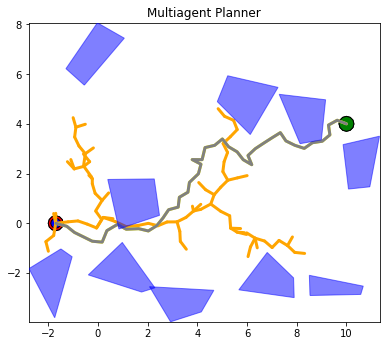

Runtime completed. Time:  43


In [3]:
# create a plan for 1 agent
example_plan = Plan([Agent("normal", test_received_bid, test_received_waypoints, start_pos, goal_site, env, 0.5, 200)],
                    env, 
                    example_dma_indiv, 
                    100,
                    viz_trees=True)

# execute the plan through at most 50 planning cycles
example_plan.spin(50)

Feel free to run the plan with different parameters or run it as many times as you'd like - you should see a different path created each time due to the nondeterminism of sampling-based methods like RRT. Now let's analyze the behavior of this implementation of RRT*.

### Conceptual Question 1 - RRT (10 pts) <a id="concept1"/>

While RRT is usually allowed to continue generating paths until a path to the goal is found, our implementation of RRT* has a time limit for generating paths before it must pick and execute the best one according to a Euclidean distance heuristic between the end node of each path and the goal. After it completes execution, it starts building a new tree from scratch. This means there is no guarantee that the agent is generating paths that reach the goal at any given timestep.

We'd like you to brainstorm the pros and cons of a fixed time limit for path planning in RRT. How does a fixed time limit impact the overall optimality of the complete path? In what situations would a fixed time limit be preferrable to an unlimited time limit? Why?

It depends on the variant of RRT. For vanilla RRT, a fixed time limit does not impact the optimality of the system. For RRT\*, a fixed time limit will reduce the optimality of the system because it effectively prevents RRT\* from iterating on the goal path enough times to approach optimality.

Given RRT is an anytime algorithm, a fixed time limit simply reduces the amount of planning performed before execution. A fixed time limit is helpful when it is cheap, easy, and preferable to replan often.

### Conceptual Question 2 - Coordination (10 pts) <a id="concept2"/>

Why kind of problems are created when all agents are allowed to replan independently and in parallel? Does a round-robin approach address all the issues? Why or why not?

If agents replan independently and in parallel, agents will not be using guaranteed information about the paths of their peers. As such, paths may collide because agents are planning against outdated peer paths. Additionally, not all agents always need to replan. It is possible for RRT\* to produce nearly optimal plans, which means that constant replanning is not a necessity for all agents.

A round-robin approach does address the issue of stale information. If agents take turns replanning, they can be sure that they are planning against up-to-date information about their peers positions. A round-robin approach does not address the issue of unnecessary replanning, as all agents will spend equal amounts of time replanning regardless of the optimality of their current plans.

### Conceptual Question 3 - Negative Bids (10 pts) <a id="concept3"/>

If you haven't already, now is a good time to review the DMA-RRT algorithm in the tutorial. In it, a bid is defined as the difference between the cost of the current path and the cost of the best path in the tree. With that in mind, is it possible for an agent to advertise a negative bid? Why or why not? What would a negative bid signify regarding comparative path costs?

No, it is not possible for an agent to produce a negative bid. A negative bid would signify that the best plan is worse than the plan they are currently executing. Bids are only generated from plans that create cost benefits.

## Implement DMA-RRT (20 pts x 2 = 40 pts) <a id="DMA-RRT"/>

We have provided you with RRT* for each agent, but as we dicussed in lecture, having each agent run RRT on its own in isolation can lead to collisions between agents. We must therefore implement DMA-RRT such that the agents can coordinate their planning as a team and avoid collisions. Note that for simplicity's sake, we'll be using a slimmed-down implementation of DMA-RRT under-the-hood that treats agents like points and does not use realistic vehicle dynamics. Don't worry though, this shouldn't affect your answers to the coding questions below.

DMA-RRT has two components: individual and interaction. We will ask you to fill out several helper functions to complete the functionality of each component: helper functions to compute the winner of the PPI bidding and to compute a PPI bid based on paths returned by RRT (these will complete the individual component), and the functions that are called every time an agent receives a bid or a waypoints message from another agent (these make up the interaction component).

Refer to the tutorial if you are confused about what is expected from these functions. In implementing your solutions, please be aware of the following functionalities that are already implemented for you.

The `Agent` class has an `antenna` attribute of type `Antenna` that allows it to communicate with other agents. This is fully implemented for you; you can call the `Agent.broadcast_bid` method to send a PPI bid to the other agents, and the `Agent.broadcast_waypoints` method to send an updated plan and a winner ID (the ID of the agent who won the right to hold the token by having the highest PPI bid) to the other agents. Each `Antenna` also has an attribute `uuid` that acts as a unique ID for each agent. You can compare `uuid` IDs using `==`. The `Agent` class also has an attribute `rrt` of type `RRTstar` that acts as an internal RRT planner. The paths returned by this planner are of type `Path`, and every `Path` object has a `cost` attribute that you can access to determine the cost of that path when calculating PPI (potential path improvement) to make bids. Finally, each `Agent` also has the following attributes:

+ `curr_plan` - a `Path` representing the agent's current plan that it is acting on.
+ `best_plan` - a `Path` representing the best path returned by the agent's RRT planner so far.
+ `bids` - a dictionary mapping other agents' IDs to the last PPI bid they broadcasted.
+ `other_agent_plans` - a dictionary mapping other agents' IDs to the last path they broadcasted.
+ `token_holder` - a Boolean indicating whether that agent currently holds the token.

First, you will implement the following helper methods for the interaction component, which has been implemented to run in the background via the `Antenna` interface. These functions are automatically and appropriately called whenever bid or waypoints messages are sent .

<div class="alert alert-info">
Complete the functions below.
</div>

In [4]:
def received_bid(agent, sender_id, msg):
    """ If the agent is not the one who sent the message, updates
        its `bids` dictionary to reflect the bid of the agent who did
        send the message.

        sender_id - the id of the agent who sent the message
        msg - a dictionary containing the PPI bid of the agent who
        sent the message under the key "bid"
    """
    ### BEGIN SOLUTION
    if sender_id != agent.antenna.uuid:
        agent.bids[sender_id] = msg["bid"]
    ### END SOLUTION

def received_waypoints(agent, sender_id, msg):
    """ If the agent is the winner, updates its state to become the
        token holder.

        If the agent is not the one who sent the message, also updates its
        `other_agent_plans` dictionary to reflect the updated plan of the
        agent who did send the message.

        sender_id - the id of the agent who sent the message
        msg - a dictionary containing the id of the winning agent under
        the key "winner_id", as well as the updated plan of the agent who
        sent the message under the key "plan"
    """
    ### BEGIN SOLUTION
    if msg["winner_id"] == agent.antenna.uuid:
        agent.token_holder = True

    if sender_id != agent.antenna.uuid:
        agent.other_agent_plans[sender_id] = msg["plan"]
    ### END SOLUTION

In [5]:
test_antenna_callback_bids(received_bid, received_waypoints)
test_antenna_callback_waypoints(received_bid, received_waypoints)
test_ok()

running test_antenna_callback_bids...

running test_antenna_callback_waypoints...



Tests passed!!

Now implement the following functions that are used in the individual component. The input to both is an `Agent` class object, which has access to the attributes listed above. In particular, `curr_plan`, `best_plan`, and `bids` will be useful to you.

Optionally, you may use Python's `random` library, which has been imported at the top of this notebook.

<div class="alert alert-info">
Complete the functions below.
</div>

In [6]:
def compute_winner(agent):
    """ Returns the id of the agent with the highest PPI (potential path
        improvement) bid, based on the bid information in the agent's
        `bids` dictionary.

        Assumes the agent's `bids` dictionary contains at least one bid.
    """
    ### BEGIN SOLUTION
    winner_bid = max(agent.bids.values())
    winner_ids = [id for id, bid in agent.bids.items() \
        if bid == winner_bid]
    winner_id = random.choice(winner_ids)
    return winner_id
    ### END SOLUTION

def bid(agent):
    """ Calculates and broadcasts the agent's bid of its 
        potential path improvement (PPI).
        
        Recall that the PPI is defined to be the difference between the 
        agent's current path and the best path returned by its RRT planner,
        representing how much better of a path the agent could have if
        given the opportunity to replan.
    """
    ### BEGIN SOLUTION
    agent.broadcast_bid(agent.curr_plan.cost - agent.best_plan.cost)
    ### END SOLUTION

In [7]:
test_compute_winner(received_bid, received_waypoints, compute_winner)
test_bid(received_bid, received_waypoints, bid)
test_ok()

running test_compute_winner...

running test_bid...



Tests passed!!

Now we provide the full implementation of the individual component, using the helper methods you provided above. Run this as-is:

In [8]:
def dma_individual(self, agent):
    """ Individual component of DMA-RRT as described in algorithm 4
        from Desaraju/How 2012.

        If this agent is the TokenHolder, it will update its internal
        plan and broadcast the next winner. Otw, it will broadcast its bid.
    """
    # Grow the tree by one set of iterations
    agent.rrt.spin(False)

    # Find the new best path in the tree
    new_plan = agent.rrt.get_path()

    # Assign first "current path" found
    if not agent.curr_plan.nodes:
        agent.curr_plan = new_plan
    agent.best_plan = new_plan

    if agent.token_holder:
        # Replan to new best path
        agent.curr_plan = agent.best_plan

        # Solve collisions with time reallocation
        agent.curr_plan = Plan.multiagent_aware_time_realloc(agent.curr_plan,
            agent.other_agent_plans)

        # Broadcast the new winner of the bidding round
        if agent.bids:
            agent.token_holder = False
            winner_id = compute_winner(agent)
            agent.broadcast_waypoints(winner_id)
    else:
        bid(agent)

    # Prevent agent from getting the token if they finish.
    if agent.at_goal():
        agent.broadcast_bid(-1000.0)
        
    # Refresh environment to reflect agent's current positions
    agent.rrt.update_pos(agent.pos, self.curr_time, wipe_tree=True)

Execute the cell below to visualize your planner in real time!

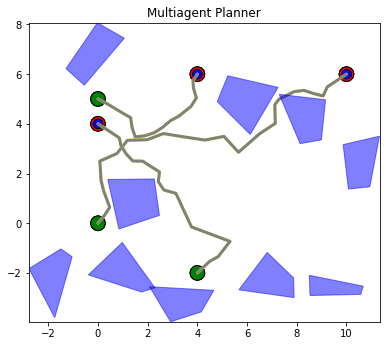

Runtime completed. Time:  42


In [9]:
agents = [Agent("normal", received_bid, received_waypoints, [0, 0], [10, 6], env, 0.5, 200),
          Agent("normal", received_bid, received_waypoints, [0, 5], [4, 6], env, 0.5, 200),
          Agent("normal", received_bid, received_waypoints, [4, -2], [0, 4], env, 0.5, 200)]

plan = Plan(agents, env, dma_individual, 100)

plan.spin(75)

## Cooperative DMA-RRT <a id="cooperative-dma-rrt"/>

Cooperative DMA-RRT layers a protocol, on top of DMA-RRT's bidding process, for asking other agents to alter their plans on. Using the notion of broadcasting "emergency stops" alongside waypoints, Cooperative DMA-RRT claims to improve the global optimality of the system. See the tutorial for more information.

### Conceptual Question 4 - Global optimality vs. risk (10 pts) <a id="concept4"/>

Let's think about risk at a high level. How does the global optimality of a system of distributed agents impact the risk associated with path planning? Would you expect that agents would take on more risk in a more optimized system? Less risk? Why or why not?

A more optimized plan is one where agents are taking more direct routes to goals. Take the idea of an street intersection as an example. In a fully optimized system, agents would slightly alter their speed to adjust their timing on approach to the intersection to narrowly avoid cross traffic. Humans are unable to do this, so instead we use a less optimized system of taking turns. This increases the distance between vehicles. In a similar way, agents in a more optimized system would be willing to create paths that approach closer to one another, hence increasing risk.

## Performance Analysis <a id="analysis"/>

RRT* and DMA-RRT have many parameters for performance tuning. Let's take a look at one of the more impactful - $\Delta t$, or the amount of time permitted during RRT to grow trees. $\Delta t$ corresponds to `rrt_iters`, or the number of iterations of RRT tree-growth to run during planning, in the `Agent` constructor API. In the next cells, use your implementation of DMA-RRT to experiment with the impact of modifying `rrt_iters`.

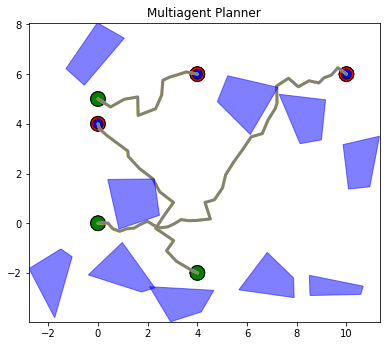

Runtime completed. Time:  55


In [10]:
rrt_iters = 200

agents = [Agent("normal", received_bid, received_waypoints, [0, 0], [10, 6], env, 0.4, rrt_iters),
          Agent("normal", received_bid, received_waypoints, [0, 5], [4, 6], env, 0.4, rrt_iters),
          Agent("normal", received_bid, received_waypoints, [4, -2], [0, 4], env, 0.4, rrt_iters)]

plan = Plan(agents, env, dma_individual, 100)
plan.spin(75)

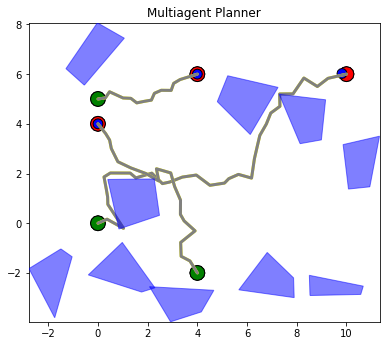

Runtime completed. Time:  57


In [11]:
rrt_iters = 300

agents = [Agent("normal", received_bid, received_waypoints, [0, 0], [10, 6], env, 0.4, rrt_iters),
          Agent("normal", received_bid, received_waypoints, [0, 5], [4, 6], env, 0.4, rrt_iters),
          Agent("normal", received_bid, received_waypoints, [4, -2], [0, 4], env, 0.4, rrt_iters)]

plan = Plan(agents, env, dma_individual, 100)
plan.spin(75)

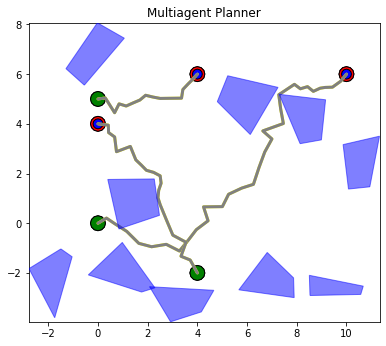

Runtime completed. Time:  54


In [13]:
rrt_iters = 400

agents = [Agent("normal", received_bid, received_waypoints, [0, 0], [10, 6], env, 0.4, rrt_iters),
          Agent("normal", received_bid, received_waypoints, [0, 5], [4, 6], env, 0.4, rrt_iters),
          Agent("normal", received_bid, received_waypoints, [4, -2], [0, 4], env, 0.4, rrt_iters)]

plan = Plan(agents, env, dma_individual, 100)
plan.spin(75)

### Conceptual Question 5 - The Impact of $\Delta t$ (10 pts) <a id="concept5"/>

How does $\Delta t$ impact the performance of DMA-RRT? If you were implementing a real-world version of DMA-RRT, what metrics would you use to tune the planning time of your agents?

As $\Delta t$ grows, DMA-RRT slows down. Agents are allowed more time to plan. With RRT\* that means the paths are potentially more optimized, but it comes at the cost of taking longer for each turn to complete.

In the real world, I would compare the time it takes to replan to the total execution time. I would increase the planning time until such a point that it was non-negligible in comparison to the execution time. I would expect that planning should be done while executing, and as such so long as there is little chance of planning taking longer than executing, I would be comfortable increasing the planning time.

### Conceptual Question 6 - Limitations of DMA-RRT (10 pts) <a id="concept6"/>

How would DMA-RRT scale with the number of agents? We only simulated environments with a few agents in this problem set, but could it feasibly be run with 100s or 1000s of independent agents? Why or why not?

The two factors that will determine the scalability of DMA-RRT is the time it takes to model peer paths and the time to bid.

Any lag or communication issues in the network of agents will dramatically impact the time to bid. Our implementation modeled a fully-connected, lag-free network of agents. So long as all agents can communicate, bidding should be a quick process regardless of the number of agents. However, any real world system would need to address communication delays and dropouts. If not, a single agent with communication issues would inhibit the bidding process, slowing down planning across all agents.

Assuming it remains computationally cheap to model the paths of other agents, then it seems likely that DMA-RRT could scale to high numbers of agents. 

## **You're Done!**
Don't forget to validate your notebook and submit.